# Traning model specificly for wearable devices

Since, we decided that best two models we had are CNN and GRU architectures, we can combine them to create a hybrid model that leverages the strengths of both. We inspected wearable device sensor data and found out that it can work only with five features and we reduced imput size from 16 to 5 features. Now, with base models that we implemented and start we suspected that last ones could be overfitting the data, so after traning this one on edited dataset (only features we need `train-wearable.csv`) and we tested on (`test-wearable.csv`) we got results that are more realistic (probably dont overfitting that much). At the end we export it as torch model for andriods so it can work on wearable devices.

In [1]:
# ==========================================
# 0. IMPORTS
# ==========================================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.mobile_optimizer import optimize_for_mobile

In [2]:
# ==========================================
# 1. SETTINGS & FEATURES
# ==========================================
TRAIN_PATH = 'data/train-wearable.csv'
TEST_PATH = 'data/test-wearable.csv'
WINDOW_SIZE = 30
BATCH_SIZE = 64
EPOCHS = 40
LEARNING_RATE = 1e-3

# Feature list
FEATURES = ['MEAN_RR', 'SDRR', 'RMSSD', 'HR', 'pNN50', 'SD1', 'SD2', 'LF', 'HF', 'LF_HF']
INPUT_DIM = len(FEATURES)
LABEL_MAP = {'no stress': 0, 'interruption': 1, 'time pressure': 2}

In [3]:
# ==========================================
# 2. DATA PREPARATION
# ==========================================
class StressDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

def create_windows(df, scaler=None, is_train=True):
    # Scale features
    if is_train:
        scaler = StandardScaler()
        df[FEATURES] = scaler.fit_transform(df[FEATURES])
    else:
        df[FEATURES] = scaler.transform(df[FEATURES])

    df['label'] = df['condition'].map(LABEL_MAP)
    data = df[FEATURES].values
    labels = df['label'].values

    X_list, y_list = [], []
    for i in range(len(df) - WINDOW_SIZE):
        X_list.append(data[i : i + WINDOW_SIZE])
        y_list.append(labels[i + WINDOW_SIZE - 1])
    
    return np.array(X_list), np.array(y_list), scaler

# Load and process data
print(">>> Processing Data...")
df_train_full = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

X_train_all, y_train_all, fitted_scaler = create_windows(df_train_full, is_train=True)
X_test, y_test, _ = create_windows(df_test, scaler=fitted_scaler, is_train=False)

# Validation split from training data
split = int(0.8 * len(X_train_all))
train_loader = DataLoader(StressDataset(X_train_all[:split], y_train_all[:split]), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(StressDataset(X_train_all[split:], y_train_all[split:]), batch_size=BATCH_SIZE)
test_loader = DataLoader(StressDataset(X_test, y_test), batch_size=BATCH_SIZE)

>>> Processing Data...


In [4]:
# ==========================================
# 3. CNN-GRU HYBRID MODEL
# ==========================================
class StressModel(nn.Module):
    def __init__(self, input_dim):
        super(StressModel, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(input_dim, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        self.gru = nn.GRU(64, 32, num_layers=2, batch_first=True, dropout=0.2)
        self.classifier = nn.Sequential(
            nn.Linear(32, 16), nn.ReLU(), nn.Linear(16, 3)
        )

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.conv(x)
        x = x.transpose(1, 2)
        _, h_n = self.gru(x)
        return self.classifier(h_n[-1])

In [5]:
# ==========================================
# 4. TRAINING & EVALUATION
# ==========================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = StressModel(INPUT_DIM).to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

history = {'train_loss': [], 'val_f1': []}

for epoch in range(EPOCHS):
    model.train()
    t_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
    
    # Quick Validation
    model.eval()
    vp, vt = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            out = model(xb.to(device))
            vp.extend(out.argmax(1).cpu().numpy())
            vt.extend(yb.numpy())
    
    f1 = classification_report(vt, vp, output_dict=True, zero_division=0)['macro avg']['f1-score']
    history['train_loss'].append(t_loss/len(train_loader))
    history['val_f1'].append(f1)
    if (epoch+1) % 5 == 0: print(f"Epoch {epoch+1:02d} | Val F1: {f1:.4f}")

Epoch 05 | Val F1: 0.9441
Epoch 10 | Val F1: 0.9696
Epoch 15 | Val F1: 0.9812
Epoch 20 | Val F1: 0.9739
Epoch 25 | Val F1: 0.9856
Epoch 30 | Val F1: 0.9866
Epoch 35 | Val F1: 0.9871
Epoch 40 | Val F1: 0.9906



>>> Running Final Test on test.csv...


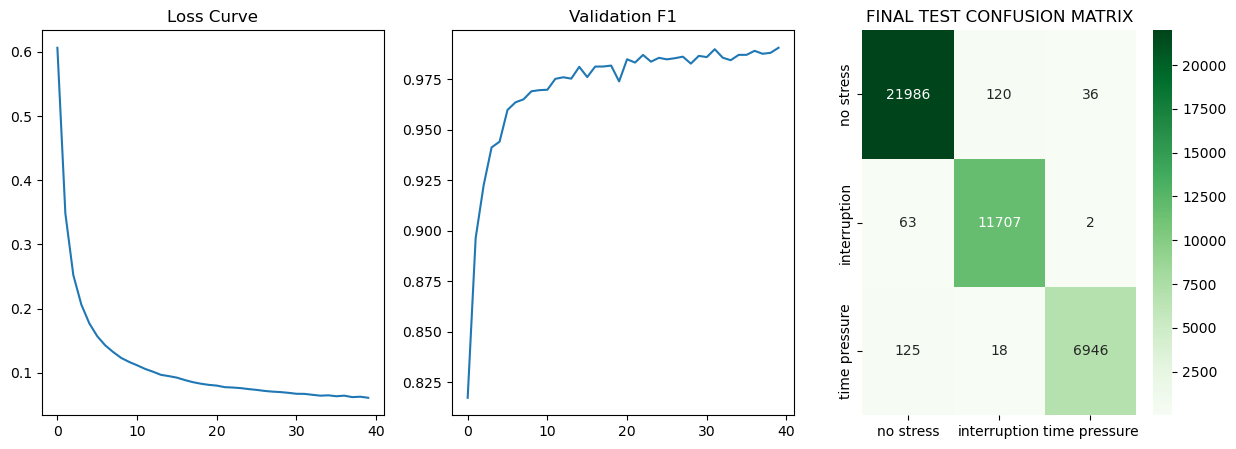


--- FINAL TEST REPORT ---
               precision    recall  f1-score   support

    no stress       0.99      0.99      0.99     22142
 interruption       0.99      0.99      0.99     11772
time pressure       0.99      0.98      0.99      7089

     accuracy                           0.99     41003
    macro avg       0.99      0.99      0.99     41003
 weighted avg       0.99      0.99      0.99     41003



In [6]:
# ==========================================
# 5. FINAL TEST EVALUATION
# ==========================================
print("\n>>> Running Final Test on test.csv...")
model.eval()
test_preds, test_targets = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        out = model(xb.to(device))
        test_preds.extend(out.argmax(1).cpu().numpy())
        test_targets.extend(yb.numpy())

# Results Visualization
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.plot(history['train_loss']); plt.title("Loss Curve")
plt.subplot(1, 3, 2); plt.plot(history['val_f1']); plt.title("Validation F1")
plt.subplot(1, 3, 3)
cm = confusion_matrix(test_targets, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=LABEL_MAP.keys(), yticklabels=LABEL_MAP.keys())
plt.title("FINAL TEST CONFUSION MATRIX")
plt.show()

print("\n--- FINAL TEST REPORT ---")
print(classification_report(test_targets, test_preds, target_names=LABEL_MAP.keys()))

In [7]:
# ==========================================
# 6. WEARABLE EXPORT (Lite Interpreter Format)
# ==========================================
model.eval().to('cpu')
scripted_model = torch.jit.script(model)
optimized_model = optimize_for_mobile(scripted_model)
optimized_model._save_for_lite_interpreter("models/wearable/stress_model.pt")
print("\n>>> Export Successful! stress_model.pt ready.")


>>> Export Successful! stress_model.pt ready.
